![alt text](title.png "")

#### The Analysis of India's International Trade will be carried out as follows:
<ol><b><li>PySpark Environment Setup</b>
<b><li>Data Source and Spark Abstraction Setup</b>
<b><li>Metadata Analysis</b>
<ul><li>3.1 Display schema and size of data
<li>3.2 Get some random samples of the dataset
<li>3.3 Data Entities, Metrics & Dimensions
<li>3.4 Drop Unnecessary Columns and optimize dataframe</ul>
<b><li>Understanding the Data</b>
<ul><li>4.1 Basic Profiling of Dataset
<li>4.2 Checking for inconsistency in data
<li>4.3 Analysing the inconsistency in the data</ul>
<b><li>Data Preparation for Analysis</b>
<ul><li>5.1 Droppinng the rows with inconsistent data
<li>5.2 Rearranging the dataset
<li>5.3 Managing the missing values in the rearranged dataframe
<li>5.4 Adding a columns for Trade Balance</ul>
<b><li>Analysis of India's Interational Trade Data</b>
<ul><li>6.1 Trade Indicators
<ul><li>a.) Annual Import Value and Change
<li>b.) Annual Export Value and Change
<li>c.) Annual Trade Balance, Change and Trade Balance Status</ul>
<li>6.2 Main Partners
<ul><li>d.) Top 5 Sellers Based on % of Imports
<li>e.) Top 5 Buyers Based on % of Exports
<li>f.) Top 5 Buyers based on number of Commodities Exported
<li>g.) Top 5 Suppliers based on number of Commodities Imported
<li>h.) Top 5 Buyers with Highest Positive Growth from 2015 to 2020
<li>i.) Top 5 Sellers with Highest Negative Growth from 2015 to 2020</ul>
<li>6.3 Main Commodities
<ul><li>j.) Top 5 Commodities Based on % of Imports
<li>k.) Top 5 Commodities Based on % of Exports
<li>l.) Top 5 Export Commodities based on number of Buyers
<li>m.) Top 5 Import Commodites based on number of Suppliers
<li>n.) Top 5 Export Commodities with Highest Positive Growth from 2015 to 2020
<li>o.) Top 5 Import Commodities with Highest Negative Growth from 2015 to 2020</ul></ul>
<b><li>Visualisation of Analysis<b></ol>

<b>Source of Dataset:</b><br>
<a href = 'https://data.gov.in/'>Open Government Data (OGD) Platform India</a>

# 1. PySpark Environment Setup

In [27]:
#importing findspark and initialising it
import findspark
findspark.init()

#importing necessary libraries
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import *
from IPython.display import *
from tabulate import *
from pandas import *
import numpy as np
from matplotlib import pyplot as plt
from string import digits
import os

#creating new spark session
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

#set working directory to the right path
os.chdir("/Users/sauravghoshroy/Desktop/IndiaInternationalTrade")

#checking current working directory
display(Markdown("**The current working directory is:**"+"  %s" % os.getcwd()))

**The current working directory is:**  /Users/sauravghoshroy/Desktop/IndiaInternationalTrade

# 2. Data Source and Spark Abstraction Setup

In [28]:
#loading the data from datasource into a spark dataframe
df = spark.read \
                 .option("inferSchema", "true") \
                 .option("header", "true") \
                 .csv("*.csv")

# 3. Metadata Analysis
## 3.1 Display schema and size of data

In [29]:
#getting the dataframe schema
df.printSchema()
df.count()
display(Markdown('The dataframe has **%d** rows' % df.count()+' and **%d** columns.'%(len(df.columns))))

root
 |-- COMMODITY: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- QUANTITY: string (nullable = true)
 |-- VALUE: double (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- TRADE: string (nullable = true)



The dataframe has **188542** rows and **7** columns.

## 3.2 Get some random samples of the dataset

In [30]:
#getting some random sample of rows from the dataset
display(Markdown("**Some random samples of the dataset:**<br>"+"%s" % df.sample(False, .0001).take(10)))

**Some random samples of the dataset:**<br>[Row(COMMODITY='PACKAGING MATERIALS', COUNTRY='SOUTH AFRICA', UNIT='TON', QUANTITY='2211', VALUE=6.752, YEAR=2019, TRADE='Export'), Row(COMMODITY='PETROLEUM PRODUCTS', COUNTRY='AFGHANISTAN', UNIT='TON', QUANTITY='465', VALUE=0.591, YEAR=2019, TRADE='Export'), Row(COMMODITY='PULSES', COUNTRY='THAILAND', UNIT='TON', QUANTITY='175', VALUE=0.288343, YEAR=2017, TRADE='Export'), Row(COMMODITY='OTHR RUBBER PRODCT EXCPT FOOTW', COUNTRY='SAMOA', UNIT='NA', QUANTITY='NA', VALUE=0.013458, YEAR=2017, TRADE='Export'), Row(COMMODITY='IC ENGINES AND PARTS', COUNTRY='UZBEKISTAN', UNIT='NA', QUANTITY='NA', VALUE=0.183347, YEAR=2017, TRADE='Export'), Row(COMMODITY='RMG MANMADE FIBRES', COUNTRY='BR VIRGN IS', UNIT='NA', QUANTITY='NA', VALUE=0.002915, YEAR=2017, TRADE='Export'), Row(COMMODITY='DRUG FORMULATIONS, BIOLOGICALS', COUNTRY='MOLDOVA', UNIT='KGS', QUANTITY='172359', VALUE=4.309215, YEAR=2015, TRADE='Export'), Row(COMMODITY='PLYWOOD AND ALLIED PRODUCTS', COUNTRY='POLAND', UNIT='NA', QUANTITY='NA', VALUE=6.497877, YEAR=2015, TRADE='Export'), Row(COMMODITY='IC ENGINES AND PARTS', COUNTRY='U S A', UNIT='NA', QUANTITY='NA', VALUE=433.923286, YEAR=2015, TRADE='Export'), Row(COMMODITY='OTHER CONSTRUCTION MACHINERY', COUNTRY='COMOROS', UNIT='NA', QUANTITY='NA', VALUE=0.041111, YEAR=2016, TRADE='Export')]

## 3.3 Data Entities, Metrics & Dimensions

Based on what we see in the random sample we can classify the fields into the following

### Data Entities:
**1. Commodity:** The class of items being exported or imported<br>
**2. Country:** The country with which in India has trade relation (could be export, import or both)<br>
**3. Unit:** The unit of quanity of each commodity being imported or exported<br>
**4. Quantity:** The amount of quantity being imported and exported<br>
**5. Value:** The value of export or import<br>
**6. Year:** The year in which the export or import happened<br>
**7. Trade:** The type of trade - export or import<br>
### Dimension:
1. Commodity
2. Country
3. Year
4. Trade

### Metrics:
1. Units of Quantity
2. Value

## 3.4 Drop Unnecessary Columns and optimize dataframe
Since there is no significant use of the Quantity and Unit columns in our business case analysis, we can drop these columns to reduce our dataset.

In [31]:
#dropping the two columns we don't need and optimizing the dataframe
df = df.drop('quantity','unit').cache()

# 4. Understanding the Data

## 4.1 Basic Profiling of Dataset

In [32]:
#getting a highlevel summary of the dataset
display(Markdown('**High level summary of dataset:**'))
df.summary().show()

**High level summary of dataset:**

+-------+--------------------+-----------+------------------+------------------+------+
|summary|           COMMODITY|    COUNTRY|             VALUE|              YEAR| TRADE|
+-------+--------------------+-----------+------------------+------------------+------+
|  count|              188542|     188542|            188542|            188542|188542|
|   mean|                null|       null| 33.93437691450789|2017.5530969227016|  null|
| stddev|                null|       null|2063.5234661889795|1.7123699215873034|  null|
|    min|AC, REFRIGERATION...|AFGHANISTAN|               0.0|              2015|Export|
|    25%|                null|       null|          0.020387|              2016|  null|
|    50%|                null|       null|          0.296282|              2018|  null|
|    75%|                null|       null|             3.235|              2019|  null|
|    max|ZINC AND PRODUCTS...|   ZIMBABWE|        514078.418|              2020|Import|
+-------+--------------------+--

## 4.2 Checking for inconsistency in data

In [33]:
#checking for Null values in each of the columns of the dataframe
display(Markdown('**Column-wise count of *Null* values in the dataset:**'))
df.select([count(when(col(c).isNull(), c)).alias(c) for c in ["commodity","country",'value',"year", "trade"]]).show()

#checking for NA values in each of the columns of the dataframe
display(Markdown('**Column-wise count of *NA* values in the dataset:**'))
df.select([count(when(col(c)=='NA', c)).alias(c) for c in ["commodity","country",'value',"year", "trade"]]).show()

#checking for N. A values in each of the columns of the dataframe
display(Markdown('**Column-wise count of *N. A* values in the dataset:**'))
df.select([count(when(col(c)=='N. A', c)).alias(c) for c in ["commodity","country",'value',"year", "trade"]]).show()

#checking for N/A values in each of the columns of the dataframe
display(Markdown('**Column-wise count of *N/A* values in the dataset:**'))
df.select([count(when(col(c)=='N/A', c)).alias(c) for c in ["commodity","country",'value',"year", "trade"]]).show()

**Column-wise count of *Null* values in the dataset:**

+---------+-------+-----+----+-----+
|commodity|country|value|year|trade|
+---------+-------+-----+----+-----+
|        0|      0|    0|   0|    0|
+---------+-------+-----+----+-----+



**Column-wise count of *NA* values in the dataset:**

+---------+-------+-----+----+-----+
|commodity|country|value|year|trade|
+---------+-------+-----+----+-----+
|        0|      5|    0|   0|    0|
+---------+-------+-----+----+-----+



**Column-wise count of *N. A* values in the dataset:**

+---------+-------+-----+----+-----+
|commodity|country|value|year|trade|
+---------+-------+-----+----+-----+
|        0|      0|    0|   0|    0|
+---------+-------+-----+----+-----+



**Column-wise count of *N/A* values in the dataset:**

+---------+-------+-----+----+-----+
|commodity|country|value|year|trade|
+---------+-------+-----+----+-----+
|        0|      0|    0|   0|    0|
+---------+-------+-----+----+-----+



The **country** column has **5** NA values. We will analyse the inconsistencies to find a way to manage them.
## 4.3 Analysing the inconsistency in the data

In [34]:
#extracting rows from the dataframe that have NA values
display(Markdown('**Analysis of inconsistency in the data:**'))
df.where(col('country')=='NA').show()

**Analysis of inconsistency in the data:**

+---------+-------+----------+----+------+
|COMMODITY|COUNTRY|     VALUE|YEAR| TRADE|
+---------+-------+----------+----+------+
|    Total|     NA|330078.093|2019|Export|
|    Total|     NA| 313361.04|2020|Export|
|    Total|     NA| 303523.19|2018|Export|
|    Total|     NA|514078.418|2019|Import|
|    Total|     NA| 474709.28|2020|Import|
+---------+-------+----------+----+------+



It is evident from the previous output that the NA values in the country column come from the total rows of the yearly data. Since we don't need these rows in the analysis of our business case, it is safe to drop them.

# 5. Data Preparation for Analysis
## 5.1 Droppinng the rows with inconsistent data

In [35]:
#dropping the 5 rows with NA values
df = df.where(df['country']!='NA').cache()

#rechecking each row of the dataframe for NA values
display(Markdown('**Count of NA in the country column reduced to 0:**'))
df.select([count(when(col(c) == 'NA', c)).alias(c) for c in ["commodity","country",'value',"year","trade"]]).show()

#getting a count of rows of the dataframe
display(Markdown('Our dataframe now has **%d** rows, **5** less than the original dataframe.' % df.count()))

**Count of NA in the country column reduced to 0:**

+---------+-------+-----+----+-----+
|commodity|country|value|year|trade|
+---------+-------+-----+----+-----+
|        0|      0|    0|   0|    0|
+---------+-------+-----+----+-----+



Our dataframe now has **188537** rows, **5** less than the original dataframe.

## 5.2 Rearranging the dataset
### Breaking the original dataframe into interim dataframes : export_data and import_data

In [36]:
#creating the export_data dataframe
export_data = df.where(col('trade')=='Export')\
                .withColumn('export value', col('value'))\
                .select('commodity','country','export value', 'year', 'trade').cache()
display(Markdown('**Dataframe containing all exports data:**'))
export_data.show()
ex_row = export_data.count() #storing the number of rows in export_data into a variable

#creating the import_data dataframe
import_data = df.where(col('trade')=='Import')\
                .withColumn('import value', col('VALUE'))\
                .select('commodity','country','import value', 'year', 'trade').cache()
display(Markdown('**Dataframe containing all imports data:**'))
import_data.show()
im_row = import_data.count() #storing the number of rows in import_data into a variable

display(Markdown("The export_data dataframe has **%d** "% ex_row+\
                 "rows and the import_data dataframe has **%d** rows." % im_row))

#getting the number of unique value in each row of the two interim dataframe
display(Markdown("**The number of unique values in each column of the export_data dataframe:**"))
export_data.select([countDistinct(c).alias(c) for c in ['commodity','country','export value', 'year', 'trade']]).show()
display(Markdown("**The number of unique values in each column of the import_data dataframe:**"))
import_data.select([countDistinct(c).alias(c) for c in ['commodity','country','import value', 'year', 'trade']]).show()

**Dataframe containing all exports data:**

+---------+-------------+------------+----+------+
|commodity|      country|export value|year| trade|
+---------+-------------+------------+----+------+
|      TEA|  AFGHANISTAN|       1.625|2019|Export|
|      TEA|      ALBANIA|       1.177|2019|Export|
|      TEA|      ALGERIA|         0.1|2019|Export|
|      TEA|      ANDORRA|       0.001|2019|Export|
|      TEA|       ANGOLA|       0.688|2019|Export|
|      TEA|      ARMENIA|       0.002|2019|Export|
|      TEA|    AUSTRALIA|       16.74|2019|Export|
|      TEA|      AUSTRIA|       0.105|2019|Export|
|      TEA|   AZERBAIJAN|       0.803|2019|Export|
|      TEA|  BAHARAIN IS|        2.25|2019|Export|
|      TEA|BANGLADESH PR|       7.433|2019|Export|
|      TEA|      BELARUS|       0.055|2019|Export|
|      TEA|      BELGIUM|       3.798|2019|Export|
|      TEA|        BENIN|       0.274|2019|Export|
|      TEA|       BHUTAN|       1.214|2019|Export|
|      TEA|     BOTSWANA|       0.004|2019|Export|
|      TEA|       BRAZIL|      

**Dataframe containing all imports data:**

+---------+--------------+------------+----+------+
|commodity|       country|import value|year| trade|
+---------+--------------+------------+----+------+
|      TEA|     ARGENTINA|       1.415|2019|Import|
|      TEA|     AUSTRALIA|       0.001|2019|Import|
|      TEA|   BAHARAIN IS|       0.006|2019|Import|
|      TEA|        BRAZIL|       0.014|2019|Import|
|      TEA|    CHINA P RP|       2.824|2019|Import|
|      TEA|       CROATIA|       0.021|2019|Import|
|      TEA|        CYPRUS|         0.0|2019|Import|
|      TEA|CZECH REPUBLIC|       0.051|2019|Import|
|      TEA|      ETHIOPIA|         0.0|2019|Import|
|      TEA|        FRANCE|       0.008|2019|Import|
|      TEA|       GERMANY|        0.34|2019|Import|
|      TEA|     HONG KONG|        0.01|2019|Import|
|      TEA|     INDONESIA|       1.252|2019|Import|
|      TEA|          IRAN|        3.76|2019|Import|
|      TEA|         ITALY|       0.022|2019|Import|
|      TEA|         JAPAN|        0.26|2019|Import|
|      TEA| 

The export_data dataframe has **128397** rows and the import_data dataframe has **60140** rows.

**The number of unique values in each column of the export_data dataframe:**

+---------+-------+------------+----+-----+
|commodity|country|export value|year|trade|
+---------+-------+------------+----+-----+
|      168|    248|       67244|   6|    1|
+---------+-------+------------+----+-----+



**The number of unique values in each column of the import_data dataframe:**

+---------+-------+------------+----+-----+
|commodity|country|import value|year|trade|
+---------+-------+------------+----+-----+
|      166|    240|       34624|   6|    1|
+---------+-------+------------+----+-----+



Since there are inconsistencies in the number of unique values in the ***commodity*** & ***country*** columns of the two dataframes, when we join them we will end up having missing values in the ***export value*** and ***import value*** columns of the combined data frame.

However, it can be said that the number of countries in the ***export_data*** frame is higher than the number of countries in the ***import_data*** dataframe because India exports to more number of countries than they import from. The same reasoning also explains the inconsistency in the number of unique values in the ***commodity*** columns of the two dataframes - India exports more commodity items than they import.

Therefore, it is safe to replace the missing values with 0 in the combined dataframe.

### Joining the two interim dataframes

In [37]:
#displaying the joined dataframe
display(Markdown("**Combined dataframe containing International trade values in the desired form:**"))

#joining the two interim dataframes to get a combined dataframe
india_trade = export_data.join(import_data, ['commodity','country','year'], 'outer')\
                         .select('country','year','commodity', 'export value', 'import value')\
                         .cache()   
india_trade.show(truncate=False)

**Combined dataframe containing International trade values in the desired form:**

+---------------+----+------------------------------+------------+------------+
|country        |year|commodity                     |export value|import value|
+---------------+----+------------------------------+------------+------------+
|BELGIUM        |2020|AC, REFRIGERATION MACHNRY ETC |9.39        |63.33       |
|C AFRI REP     |2019|AC, REFRIGERATION MACHNRY ETC |0.001       |null        |
|NEW CALEDONIA  |2016|AC, REFRIGERATION MACHNRY ETC |0.026963    |null        |
|RWANDA         |2018|AC, REFRIGERATION MACHNRY ETC |0.27        |null        |
|SYRIA          |2016|AC, REFRIGERATION MACHNRY ETC |0.282179    |null        |
|AFGHANISTAN    |2015|ACCUMULATORS AND BATTERIES    |0.456896    |null        |
|AFGHANISTAN    |2016|ACCUMULATORS AND BATTERIES    |0.561552    |null        |
|CANADA         |2016|ACCUMULATORS AND BATTERIES    |0.497739    |0.179973    |
|NETHERLAND     |2019|ACCUMULATORS AND BATTERIES    |0.571       |2.027       |
|SLOVENIA       |2020|ACCUMULATORS AND B

## 5.3 Managing the missing values in the rearranged dataframe

In [38]:
#getting the number of missing in each column of the combined dataframe
display(Markdown("**Number of missing values in each column of the india_trade dataframe:**"))
india_trade.select([count(when(col(c).isNull(), c)).alias(c) for c in ["commodity","country",'export value',\
                                                                         'import value',"year"]]).show()

**Number of missing values in each column of the india_trade dataframe:**

+---------+-------+------------+------------+----+
|commodity|country|export value|import value|year|
+---------+-------+------------+------------+----+
|        0|      0|        7012|       75269|   0|
+---------+-------+------------+------------+----+



In [39]:
display(Markdown("Since missing values are only in the ***export value*** and ***import value***\
                  columns, we will replace them with 0."))

#replacing missing values with 0
india_trade = india_trade.na.fill(0).cache()

#ensuring the rearranged dataframe does not have any missing values in any of the columns
display(Markdown("**Number of missing values in each column of the rearranged dataframe:**"))
india_trade.select([count(when(col(c).isNull(), c)).alias(c) for c in ["commodity","country",'export value',\
                                                                         'import value',"year"]]).show()

Since missing values are only in the ***export value*** and ***import value***                  columns, we will replace them with 0.

**Number of missing values in each column of the rearranged dataframe:**

+---------+-------+------------+------------+----+
|commodity|country|export value|import value|year|
+---------+-------+------------+------------+----+
|        0|      0|           0|           0|   0|
+---------+-------+------------+------------+----+



## 5.4 Adding a columns for Trade Balance
To answer our business questions, we need India's trade balance for each commodity item with each country in every year. We get this by adding a new column ***trade balance*** containing results we get by subtracting ***import value*** from corresponding ***export value*** in the india_trade dataframe.

In [40]:
#creating the trade balance column
display(Markdown("**View of final rearranged dataframe with <u>*trade balance*</u> values:**"))
india_trade = india_trade.select('country','year','commodity','export value','import value')\
                         .withColumn('trade balance', round(col('export value')-col('import value'),3))\
                         .cache()
india_trade.show(truncate = False)

display(Markdown("The dataframe has **%d** rows, which is a lot lesser than the total number \
                 of rows in our original dataframe."\
                 % india_trade.count()))

**View of final rearranged dataframe with <u>*trade balance*</u> values:**

+---------------+----+------------------------------+------------+------------+-------------+
|country        |year|commodity                     |export value|import value|trade balance|
+---------------+----+------------------------------+------------+------------+-------------+
|BELGIUM        |2020|AC, REFRIGERATION MACHNRY ETC |9.39        |63.33       |-53.94       |
|C AFRI REP     |2019|AC, REFRIGERATION MACHNRY ETC |0.001       |0.0         |0.001        |
|NEW CALEDONIA  |2016|AC, REFRIGERATION MACHNRY ETC |0.026963    |0.0         |0.027        |
|RWANDA         |2018|AC, REFRIGERATION MACHNRY ETC |0.27        |0.0         |0.27         |
|SYRIA          |2016|AC, REFRIGERATION MACHNRY ETC |0.282179    |0.0         |0.282        |
|AFGHANISTAN    |2015|ACCUMULATORS AND BATTERIES    |0.456896    |0.0         |0.457        |
|AFGHANISTAN    |2016|ACCUMULATORS AND BATTERIES    |0.561552    |0.0         |0.562        |
|CANADA         |2016|ACCUMULATORS AND BATTERIES    |0.49773

The dataframe has **135409** rows, which is a lot lesser than the total number                  of rows in our original dataframe.

Now that we have our rearranged dataframe, we are ready to begin our analysis.

# 6. Exploratory Data Analysis of India's Interational Trade Data
## 6.1 Defining functions needed for the analysy
Since we will be using the same bundle of code with different variables multiple times, it is better to define functions that can be used repeatedly.

**For our given analysis we will define 4 functions to compute:**
1. Totals of and change in import value, export value and trade balance by year
2. Top 5 countries/commodities based on % of total export/import value by year
3. Top 5 countries/commodities based on number of import/export trades by year
4. Top 5 countries/commodities based on maximum positive/negative growth of export/import values by year


In [41]:
#total number of trading countries/commodities by year
def count_x(df, column, typ = None, year=None): #if typ is mentioned computation will be done only for that
                                                #if year parameter is mentioned, computation will done only for that year
    alias1 = 'number of sellers' if column == 'country' else 'number of commodities bought'
    alias2 = 'number of buyers' if column == 'country' else 'number of commodities sold'
    alias3 = 'number of trade partners' if column == 'country' else 'number of commodities traded'
    a = df.where(col('import value')>0)\
          .groupBy('year')\
          .agg(countDistinct(column).alias(alias1))\
          .orderBy('year').cache()
    b = df.where(col('export value')>0)\
          .groupBy('year')\
          .agg(countDistinct(column).alias(alias2))\
          .orderBy('year').cache()
    c = india_trade.groupBy('year')\
                   .agg(countDistinct(column).alias(alias3))\
                   .orderBy('year').cache()
    if typ == None:
        result = c.join(a, ['year'],'outer')\
                  .join(b, ['year'],'outer')\
                  .orderBy('year')
    elif typ == 'import':
        result = a
    elif typ == 'export':
        result = b
    elif typ == 'all':
        result = c
    if year == None:
        result = result.toPandas().set_index('year')
    else:
        result = result.where(col(column)==year)\
                       .toPandas().set_index('year')
    return(result)

#Totals of and change in import value, export value or trade balance by year
def total_and_growth(df, column1, column2,year=None): #if year parameter is mentioned,
                                                      #computation will done only for that year
    growth = 'growth in'+' '+column2
    percentage_growth = '%'+' '+ growth
    percent = '% of total '+ column2
    growth_window = Window.partitionBy().orderBy(column1)  
    result = df.groupBy(column1)\
               .agg(round(sum(column2),3).alias(column2))\
               .cache()
    b = result.agg(sum(column2)).first()[0] 
    check = udf(lambda y: 'deficit' if y < 0 else 'surplus')
    result = result.select(column1, column2)\
                   .withColumn(percent,round(col(column2)/b*100,3))\
                   .withColumn('y', lag(column2).over(growth_window))\
                   .withColumn(growth, round(col(column2)-col('y'),3))\
                   .withColumn(percentage_growth,\
                               round(col(growth)/abs(col('y'))*100,3))\
                   .select(column1,column2,growth,percentage_growth)\
                   .cache()
    if year == None:
        result = result
    else:
        result = result.where(col(column1)==year)
    if column2 == 'trade balance':
        result = result.withColumn("deficit/surplus",check(column2))\
                       .toPandas().set_index(column1)
    else:
        result = result.toPandas().set_index(column1)
    return result

#Top 5 countries/commodities based on export/import value by year
def top_by_value(df,column1,column2,column3,n,year=None): #if year parameter is mentioned,
                                                      #computation will done only for that year
    contribution = '% of total '+column3.split()[0]
    alias = column2+' of '+column3.split()[0]
    w = Window.partitionBy(column1).orderBy(col(column3).desc())
    y = Window.partitionBy(column1).orderBy(col(column1))
    change_window = Window.partitionBy().orderBy(column1)
    result = df.groupBy(column1,column2)\
               .agg(sum(column3).alias(column3))\
               .withColumn("rn", row_number().over(w))\
               .withColumn('total', sum(column3).over(y))\
               .withColumn(contribution,round(col(column3)/col('total')*100,3))\
               .where(col('rn')<= n)\
               .cache()\
               .groupBy(column1)\
               .pivot('rn')\
               .agg(first(column2).alias(alias),first(contribution).alias(contribution))\
               .orderBy(column1)\
               .cache()
    l = result.columns
    cols = [c.replace(r'_',') ').strip() for c in l]
    if year == None:
        result = result.toDF(*cols)\
                       .toPandas().set_index(column1)
    else:
        result = result.where(col(column1)==year).toDF(*cols)\
                                                 .toPandas().set_index(column1)
    return result

#Top 5 countries/commodities based on number of import/export trades by year
def top_by_count(df,column1,column2,column3,n,year=None): #if year parameter is mentioned,
                                                      #computation will done only for that yeara
    alias = 'number of countries traded with' if column2 == 'commodity' else\
            'number of commodities exported'if column2 == 'country' and column3 == 'export value' else\
            'number of commodities imported'
    w = Window.partitionBy(column1).orderBy(col(alias).desc())
    result = df.where(col(column3)>0)\
                .groupBy(column1, column2)\
                .agg(count(col(column2)).alias(alias))\
                .orderBy(col(column1).desc(), col(alias).desc())\
                .withColumn("rn", row_number().over(w))\
                .where(col('rn')<=n)\
                .cache()\
                .groupBy(column1)\
                .pivot('rn')\
                .agg(first(column2).alias(column2),first(alias).alias(alias))\
                .orderBy(column1)\
                .cache()
    if year == None:
        result = result.toPandas().set_index(column1)
    else:
        result = result.where(col(column1)==year)\
                       .toPandas().set_index(column1)
    return result

#Top 5 countries/commodities based on maximum positive/negative growth of export/import values by year
def gain(df,column1, column2, column3,order,n, start_year = None, end_year = None): #if star_year and end_year 
                                                                                    #parameter is mentioned,
                                                                                    #computation will done only for 
                                                                                    #years in between them
    if start_year == None:
        start_year = str(df.select(column1).agg(min(column1)).first()[0])
    if end_year == None:
        end_year = str(df.select(column1).agg(max(column1)).first()[0])
    result = df.groupBy(column1, column2)\
               .agg(sum(column3).alias(column3))\
               .where((col(column1) == start_year) | (col(column1) == end_year))\
               .na.fill(0)\
               .cache()\
               .groupBy(column2)\
               .pivot(column1)\
               .agg(max(col(column3)))\
               .fillna(0)\
               .cache()\
               .withColumn('gain', round(col(end_year)-col(start_year),3))\
               .select(column2,start_year,end_year,'gain')\
               .cache()
    if order==desc:
        result = result.orderBy(col('gain').desc()).limit(n).toPandas()
    else:
        result = result.orderBy(col('gain').asc()).limit(n).toPandas()
    result.index = np.arange(1, len(result)+1)
    return result

## 6.1 Trade Indicators

In [42]:
#Annual Import Value and Change
a = total_and_change(india_trade,'year','import value')
display(Markdown("<h3>a.) Annual Import Value and Change</h3>"),a,Markdown('<br>'))

#Annual Export Value and Change
b = total_and_change(india_trade,'year','export value')
display(Markdown("<h3>b.) Annual Export Value and Change</h3>"),b,Markdown('<br>'))

#Annual Trade Balance, Change and Trade Balance Status
c = total_and_change(india_trade,'year','trade balance')
display(Markdown("<h3>c.) Annual Trade Balance, Change and Trade Balance Status</h3>"),c,Markdown('<br>'))

<h3>a.) Annual Import Value and Change</h3>

,import value,change in import value,% change in import value
year,,,
2015,448033.409,NaN,NaN
2016,381006.629,-67026.780,-14.960
2017,382740.943,1734.314,0.455
2018,465579.740,82838.797,21.644
2019,514078.371,48498.631,10.417
2020,474707.520,-39370.851,-7.659


<br>

<h3>b.) Annual Export Value and Change</h3>

,export value,change in export value,% change in export value
year,,,
2015,310352.009,NaN,NaN
2016,262290.125,-48061.884,-15.486
2017,276547.001,14256.876,5.436
2018,303523.190,26976.189,9.755
2019,330077.903,26554.713,8.749
2020,313368.430,-16709.473,-5.062


<br>

<h3>c.) Annual Trade Balance, Change and Trade Balance Status</h3>

,trade balance,change in trade balance,% change in trade balance,deficit/surplus
year,,,,
2015,-137681.508,NaN,NaN,deficit
2016,-118716.591,18964.917,13.774,deficit
2017,-106193.973,12522.618,10.548,deficit
2018,-162056.550,-55862.577,-52.604,deficit
2019,-184000.468,-21943.918,-13.541,deficit
2020,-161339.090,22661.378,12.316,deficit


<br>

## 6.2 Main Partners

In [23]:
#Top 5 Sellers Based on % of Imports
d = topx(india_trade,'year','country','import value',5)
display(Markdown('<h3>d.) Top 5 Sellers Based on % of Imports</h3>'),d.T,Markdown('<br>'))

#Top 5 Buyers Based on % of Exports
e = topx(india_trade,'year','country','export value',5)
display(Markdown('<h3>e.) Top 5 Buyers Based on % of Exports</h3>'),e.T,Markdown('<br>'))

#Top 5 Buyers based on number of Commodities Exported
f = count_x(india_trade,'year','country','export value',5)
display(Markdown('<h3>f.) Top 5 Buyers based on number of Commodities Exported</h3>'),f.T,Markdown('<br>'))

#Top 5 Suppliers based on number of Commodities Imported
g = count_x(india_trade,'year','country','import value',5)
display(Markdown('<h3>g.) Top 5 Suppliers based on number of Commodities Imported</h3>'),g.T,Markdown('<br>'))

#Top 5 Buyers with Highest Positive Growth from 2015 to 2020
h = gain(india_trade,'year','country','export value',desc,5)
display(Markdown('<h3>h.) Top 5 Buyers with Highest Positive Growth from 2015 to 2020</h3>'),h,Markdown('<br>'))

#Top 5 Sellers with Highest Negative Growth from 2015 to 2020
i = gain(india_trade,'year','country','import value',asc,5)
display(Markdown('<h3>i.) Top 5 Sellers with Highest Negative Growth from 2015 to 2020</h3>'),i,Markdown('<br>'))

<h3>d.) Top 5 Sellers Based on % of Imports</h3>

year,2015,2016,2017,2018,2019,2020
1) country of import,CHINA P RP,CHINA P RP,CHINA P RP,CHINA P RP,CHINA P RP,CHINA P RP
1) import value,60413.2,61706.8,61310.6,76380.8,70319.6,65260.7
1) % of total import,13.484,7.443,5.06,4.554,3.209,2.448
2) country of import,SAUDI ARAB,U S A,U S A,U S A,U S A,U S A
2) import value,28107.6,21781.4,22103.6,26611,35550.2,35820.7
2) % of total import,6.274,2.627,1.824,1.586,1.622,1.344
3) country of import,U ARAB EMTS,SAUDI ARAB,U ARAB EMTS,SAUDI ARAB,U ARAB EMTS,U ARAB EMTS
3) import value,26139.9,20321.3,21470.7,22069.9,29787.2,30265.9
3) % of total import,5.834,2.451,1.772,1.316,1.359,1.135
4) country of import,SWITZERLAND,U ARAB EMTS,SAUDI ARAB,U ARAB EMTS,SAUDI ARAB,SAUDI ARAB


<br>

<h3>e.) Top 5 Buyers Based on % of Exports</h3>

year,2015,2016,2017,2018,2019,2020
1) country of export,U S A,U S A,U S A,U S A,U S A,U S A
1) export value,42464.2,40339.8,42331.8,47882.3,52427.5,53108.7
1) % of total export,13.683,7.045,4.985,4.154,3.536,2.957
2) country of export,U ARAB EMTS,U ARAB EMTS,U ARAB EMTS,U ARAB EMTS,U ARAB EMTS,U ARAB EMTS
2) export value,33028.1,30290,31257.7,28146.1,30127,28853.8
2) % of total export,10.642,5.29,3.681,2.442,2.032,1.606
3) country of export,HONG KONG,HONG KONG,HONG KONG,HONG KONG,CHINA P RP,CHINA P RP
3) export value,13599.9,12092.2,14157.2,14690.3,16752.8,16614.4
3) % of total export,4.382,2.112,1.667,1.274,1.13,0.925
4) country of export,CHINA P RP,CHINA P RP,CHINA P RP,CHINA P RP,HONG KONG,HONG KONG


<br>

<h3>f.) Top 5 Buyers based on number of Commodities Exported</h3>

year,2015,2016,2017,2018,2019,2020
1) country,U S A,U S A,U S A,U ARAB EMTS,U S A,NEPAL
1) number of commodities exported,160,163,161,159,162,162
2) country,U ARAB EMTS,U ARAB EMTS,U ARAB EMTS,U S A,NEPAL,U S A
2) number of commodities exported,160,160,160,158,160,159
3) country,NEPAL,NEPAL,NEPAL,NEPAL,GERMANY,U ARAB EMTS
3) number of commodities exported,159,159,159,157,159,158
4) country,U K,SAUDI ARAB,GERMANY,U K,MALAYSIA,U K
4) number of commodities exported,157,156,159,154,159,155
5) country,GERMANY,MALAYSIA,U K,GERMANY,U ARAB EMTS,MALAYSIA
5) number of commodities exported,157,156,158,151,159,152


<br>

<h3>g.) Top 5 Suppliers based on number of Commodities Imported</h3>

year,2015,2016,2017,2018,2019,2020
1) country,U S A,CHINA P RP,CHINA P RP,U S A,U S A,U S A
1) number of commodities imported,152,154,148,147,153,153
2) country,CHINA P RP,U S A,U S A,CHINA P RP,U K,GERMANY
2) number of commodities imported,151,153,147,146,152,148
3) country,GERMANY,ITALY,GERMANY,GERMANY,CHINA P RP,CHINA P RP
3) number of commodities imported,145,143,146,145,149,147
4) country,ITALY,GERMANY,ITALY,UNSPECIFIED,GERMANY,U K
4) number of commodities imported,140,141,141,139,146,146
5) country,THAILAND,FRANCE,U K,ITALY,SINGAPORE,U ARAB EMTS
5) number of commodities imported,139,141,140,137,145,143


<br>

<h3>h.) Top 5 Buyers with Highest Positive Growth from 2015 to 2020</h3>

,country,gain
1,U S A,10644.469
2,CHINA P RP,4655.907
3,NEPAL,2586.525
4,NETHERLAND,2042.023
5,BANGLADESH PR,1751.001


<br>

<h3>i.) Top 5 Sellers with Highest Negative Growth from 2015 to 2020</h3>

,country,gain
1,IRAN,-7557.754
2,UNSPECIFIED,-7465.098
3,VENEZUELA,-5672.891
4,SWITZERLAND,-5233.283
5,QATAR,-4918.753


<br>

## 6.3 Main Commodities

In [24]:
#Top 5 Commodities Based on % of Imports
j = topx(india_trade,'year','commodity','import value',5)
display(Markdown('<h3>j.) Top 5 Commodities Based on % of Imports</h3>'),j.T,Markdown('<br>'))

#Top 5 Commodities Based on % of Exports
k = topx(india_trade,'year','commodity','export value',5)
display(Markdown('<h3>k.) Top 5 Commodities Based on % of Exports</h3>'),k.T,Markdown('<br>'))

#Top 5 Export Commodities based on number of Buyers
l = count_x(india_trade,'year','commodity','export value',5)
display(Markdown('<h3>l.) Top 5 Export Commodities based on number of Buyers</h3>'),l.T,Markdown('<br>'))

#Top 5 Import Commodites based on number of Suppliers
m = count_x(india_trade,'year','commodity','import value',5)
display(Markdown('<h3>m.) Top 5 Import Commodites based on number of Suppliers</h3>'),m.T,Markdown('<br>'))

#Top 5 Export Commodities with Highest Positive Growth from 2015 to 2020
n = gain(india_trade,'year','commodity','export value',desc,5)
display(Markdown('<h3>n.) Top 5 Export Commodities with Highest Positive Growth from 2015 to 2020</h3>')\
        ,n,Markdown('<br>'))

#Top 5 Import Commodities with Highest Negative Growth from 2015 to 2020
o = gain(india_trade,'year','commodity','import value',asc,5)
display(Markdown('<h3>o.) Top 5 Import Commodities with Highest Negative Growth from 2015 to 2020</h3>')\
        ,o,Markdown('<br>'))

<h3>j.) Top 5 Commodities Based on % of Imports</h3>

year,2015,2016,2017,2018,2019,2020
1) commodity of import,PETROLEUM: CRUDE,PETROLEUM: CRUDE,PETROLEUM: CRUDE,PETROLEUM: CRUDE,PETROLEUM: CRUDE,PETROLEUM: CRUDE
1) import value,116443,65923,70716.9,87372.2,114042,102749
1) % of total import,25.99,7.952,5.836,5.209,5.204,3.854
2) commodity of import,GOLD,GOLD,GOLD,"PEARL, PRECS, SEMIPRECS STONES",GOLD,GOLD
2) import value,34407.2,31770.7,27509.8,34278.9,32910.1,28229.7
2) % of total import,7.68,3.832,2.27,2.044,1.502,1.059
3) commodity of import,"PEARL, PRECS, SEMIPRECS STONES","PEARL, PRECS, SEMIPRECS STONES","PEARL, PRECS, SEMIPRECS STONES",GOLD,"PEARL, PRECS, SEMIPRECS STONES",PETROLEUM PRODUCTS
3) import value,22598.2,20069.9,23882.5,33657.2,27075.7,27801.6
3) % of total import,5.044,2.421,1.971,2.007,1.236,1.043
4) commodity of import,PETROLEUM PRODUCTS,PETROLEUM PRODUCTS,TELECOM INSTRUMENTS,"COAL,COKE AND BRIQUITTES ETC",PETROLEUM PRODUCTS,"PEARL, PRECS, SEMIPRECS STONES"


<br>

<h3>k.) Top 5 Commodities Based on % of Exports</h3>

year,2015,2016,2017,2018,2019,2020
1) commodity of export,PETROLEUM PRODUCTS,PETROLEUM PRODUCTS,PETROLEUM PRODUCTS,PETROLEUM PRODUCTS,PETROLEUM PRODUCTS,PETROLEUM PRODUCTS
1) export value,56794.2,30582.7,31622.3,37465.1,46553.6,41288.8
1) % of total export,18.3,5.341,3.724,3.25,3.14,2.299
2) commodity of export,"PEARL, PRECS, SEMIPRECS STONES","PEARL, PRECS, SEMIPRECS STONES","PEARL, PRECS, SEMIPRECS STONES","PEARL, PRECS, SEMIPRECS STONES","PEARL, PRECS, SEMIPRECS STONES","PEARL, PRECS, SEMIPRECS STONES"
2) export value,24758.8,22297.3,25038.5,25871.7,25972,20692.5
2) % of total export,7.978,3.894,2.949,2.244,1.752,1.152
3) commodity of export,GOLD AND OTH PRECS METL JWLERY,"DRUG FORMULATIONS, BIOLOGICALS","DRUG FORMULATIONS, BIOLOGICALS","DRUG FORMULATIONS, BIOLOGICALS","DRUG FORMULATIONS, BIOLOGICALS","DRUG FORMULATIONS, BIOLOGICALS"
3) export value,13242.4,12647.8,12697.4,12909,14388.8,15940.7
3) % of total export,4.267,2.209,1.495,1.12,0.97,0.887
4) commodity of export,"DRUG FORMULATIONS, BIOLOGICALS",GOLD AND OTH PRECS METL JWLERY,GOLD AND OTH PRECS METL JWLERY,GOLD AND OTH PRECS METL JWLERY,GOLD AND OTH PRECS METL JWLERY,GOLD AND OTH PRECS METL JWLERY


<br>

<h3>l.) Top 5 Export Commodities based on number of Buyers</h3>

year,2015,2016,2017,2018,2019,2020
1) commodity,"COTTON FABRICS, MADEUPS ETC.",OTHER COMMODITIES,"DRUG FORMULATIONS, BIOLOGICALS","DRUG FORMULATIONS, BIOLOGICALS","DRUG FORMULATIONS, BIOLOGICALS","DRUG FORMULATIONS, BIOLOGICALS"
1) number of countries traded with,207,209,209,202,210,204
2) commodity,OTHER COMMODITIES,"DRUG FORMULATIONS, BIOLOGICALS",OTHER COMMODITIES,"COTTON FABRICS, MADEUPS ETC.",PRODUCTS OF IRON AND STEEL,"COTTON FABRICS, MADEUPS ETC."
2) number of countries traded with,207,206,208,196,205,197
3) commodity,"DRUG FORMULATIONS, BIOLOGICALS",RMG COTTON INCL ACCESSORIES,PRODUCTS OF IRON AND STEEL,OTHER COMMODITIES,"COTTON FABRICS, MADEUPS ETC.",OTHER COMMODITIES
3) number of countries traded with,205,203,203,195,204,196
4) commodity,RMG COTTON INCL ACCESSORIES,PRODUCTS OF IRON AND STEEL,"COTTON FABRICS, MADEUPS ETC.",RMG COTTON INCL ACCESSORIES,OTHER COMMODITIES,HANDCRFS(EXCL.HANDMADE CRPTS)
4) number of countries traded with,201,202,203,191,203,193
5) commodity,ELECTRIC MACHINERY AND EQUIPME,OTHER MISC. ENGINEERING ITEMS,HANDCRFS(EXCL.HANDMADE CRPTS),INDL. MACHNRY FOR DAIRY ETC,RMG COTTON INCL ACCESSORIES,CERAMICS AND ALLIED PRODUCTS
5) number of countries traded with,199,202,202,188,202,192


<br>

<h3>m.) Top 5 Import Commodites based on number of Suppliers</h3>

year,2015,2016,2017,2018,2019,2020
1) commodity,OTHER COMMODITIES,OTHER COMMODITIES,OTHER COMMODITIES,OTHER COMMODITIES,OTHER COMMODITIES,OTHER COMMODITIES
1) number of countries traded with,179,186,175,151,164,160
2) commodity,IRON AND STEEL,IRON AND STEEL,IRON AND STEEL,"ALUMINIUM, PRODUCTS OF ALUMINM",IRON AND STEEL,IRON AND STEEL
2) number of countries traded with,148,149,143,144,160,155
3) commodity,"ALUMINIUM, PRODUCTS OF ALUMINM","ALUMINIUM, PRODUCTS OF ALUMINM","ALUMINIUM, PRODUCTS OF ALUMINM",IRON AND STEEL,"ALUMINIUM, PRODUCTS OF ALUMINM","ALUMINIUM, PRODUCTS OF ALUMINM"
3) number of countries traded with,137,144,143,144,153,139
4) commodity,"PAPER, PAPER BOARD AND PRODUCT",ELECTRIC MACHINERY AND EQUIPME,ELECTRIC MACHINERY AND EQUIPME,COPPER AND PRDCTS MADE OF COPR,INDL. MACHNRY FOR DAIRY ETC,INDL. MACHNRY FOR DAIRY ETC
4) number of countries traded with,135,138,135,121,139,126
5) commodity,PRODUCTS OF IRON AND STEEL,INDL. MACHNRY FOR DAIRY ETC,"PAPER, PAPER BOARD AND PRODUCT","PAPER, PAPER BOARD AND PRODUCT",ELECTRONICS INSTRUMENTS,COPPER AND PRDCTS MADE OF COPR
5) number of countries traded with,131,134,132,118,133,124


<br>

<h3>n.) Top 5 Export Commodities with Highest Positive Growth from 2015 to 2020</h3>

,commodity,gain
1,ELECTRIC MACHINERY AND EQUIPME,4994.212
2,"DRUG FORMULATIONS, BIOLOGICALS",4724.847
3,TELECOM INSTRUMENTS,3732.292
4,ORGANIC CHEMICALS,2955.666
5,"ALUMINIUM, PRODUCTS OF ALUMINM",2255.418


<br>

<h3>o.) Top 5 Import Commodities with Highest Negative Growth from 2015 to 2020</h3>

,commodity,gain
1,PETROLEUM: CRUDE,-13694.127
2,GOLD,-6177.507
3,OTHER COMMODITIES,-5754.052
4,BULK MINERALS AND ORES,-3643.457
5,SILVER,-1795.712


<br>

# 7. Visualisation of Analysis
We will plot some charts of the computation of our analysis to use in the analysis report

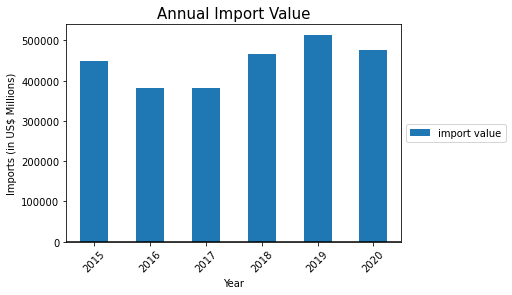

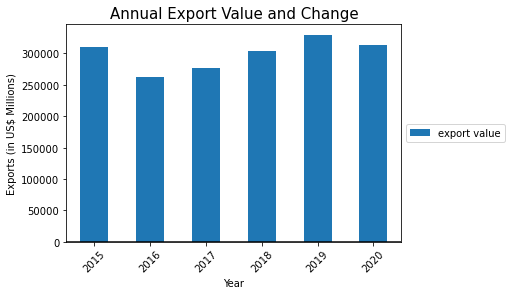

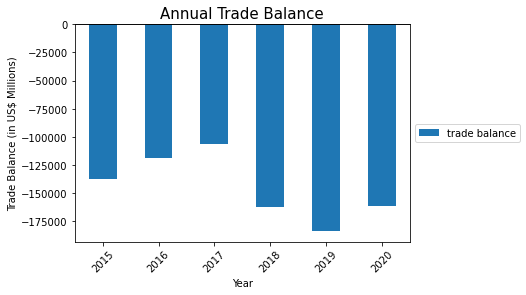

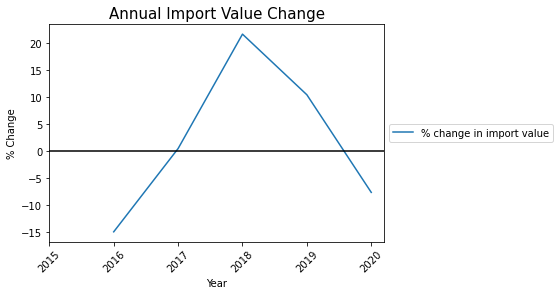

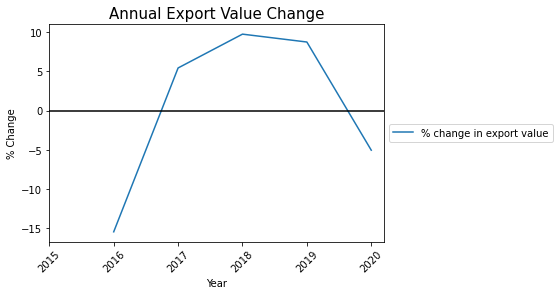

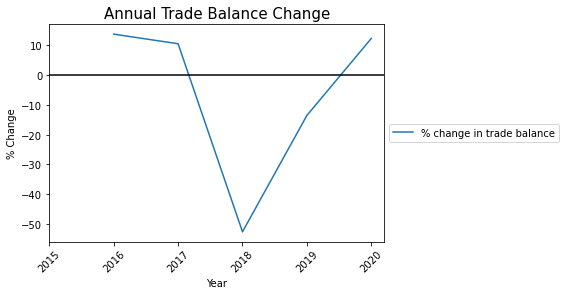

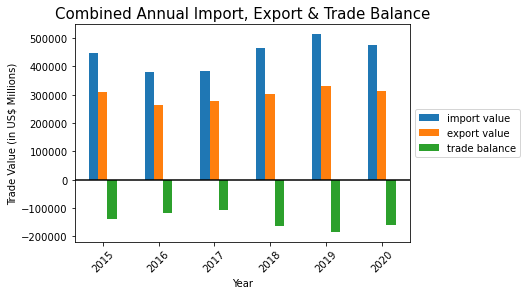

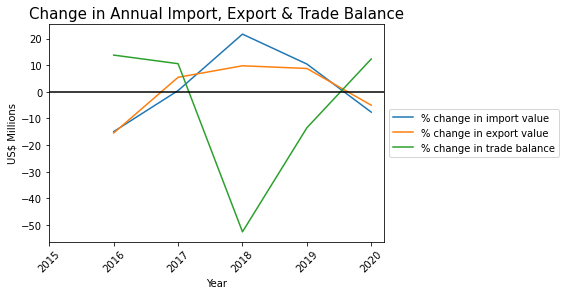

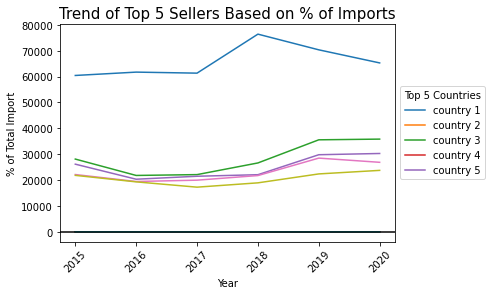

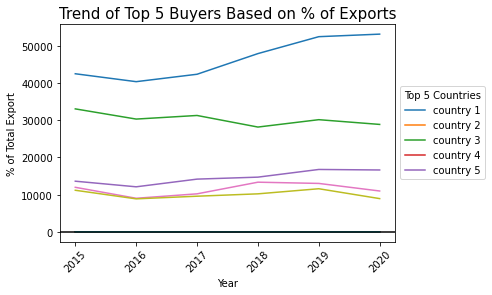

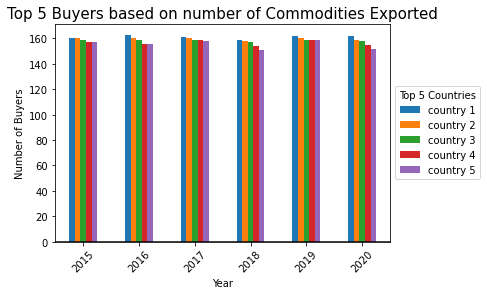

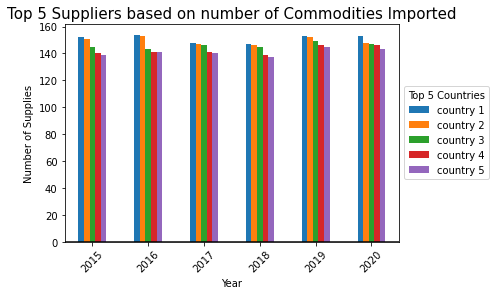

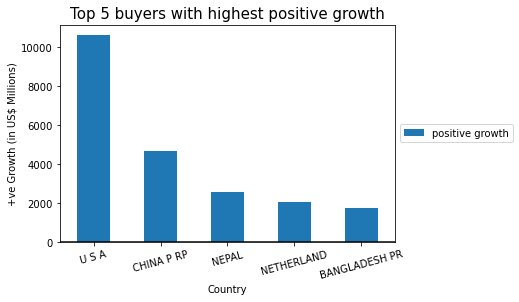

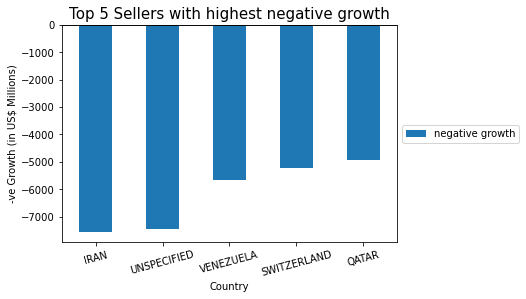

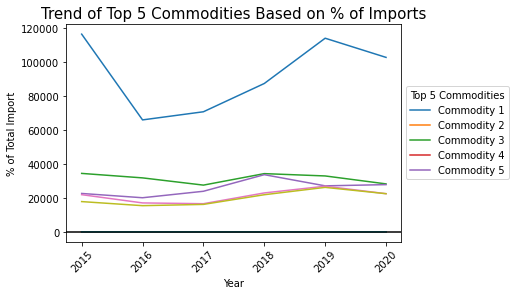

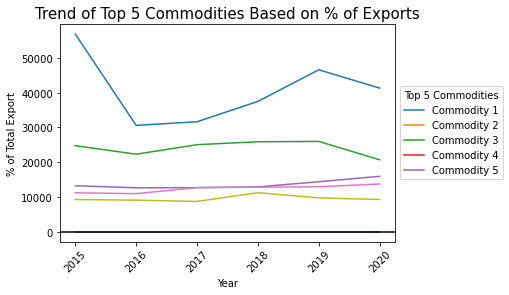

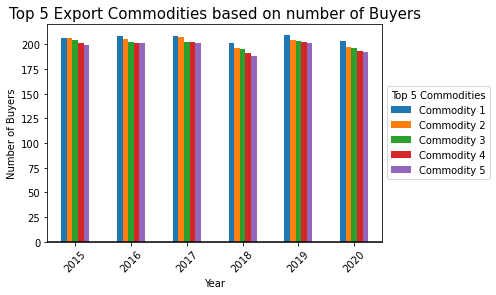

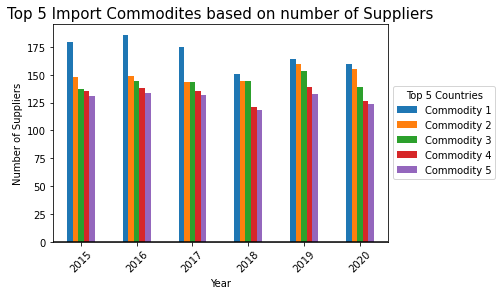

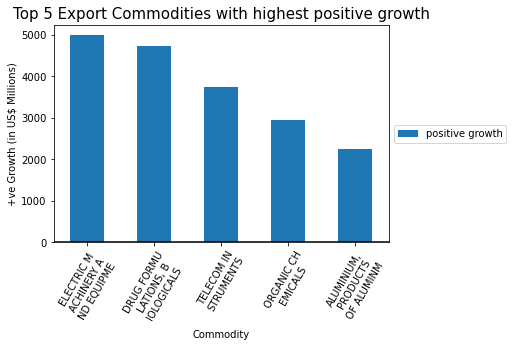

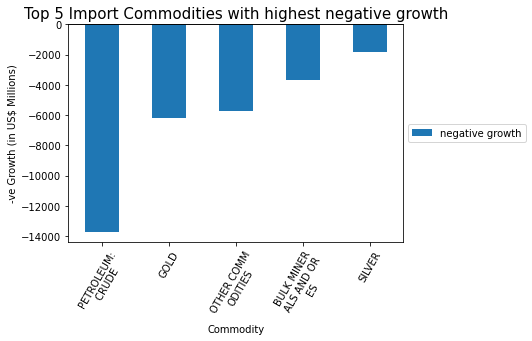

In [25]:
commodity_label = ('Commodity 1','Commodity 2','Commodity 3','Commodity 4','Commodity 5')
country_label = ('country 1','country 2','country 3','country 4','country 5')

#Annual Import Value
a.plot.bar(y=['import value'], rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('Imports (in US$ Millions)',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.axhline(color='k')
plt.title('Annual Import Value', size = 15)
plt.savefig('plots/a.png',bbox_inches='tight', transparent = True)

#Annual Export Value and Change
b.plot.bar(y=['export value'], rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('Exports (in US$ Millions)',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.axhline(color='k')
plt.title('Annual Export Value and Change', size = 15)
plt.savefig('plots/b.png',bbox_inches='tight', transparent = True)

#Annual Trade Balance
c.plot.bar(y=['trade balance'], rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('Trade Balance (in US$ Millions)',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.axhline(color='k')
plt.title('Annual Trade Balance', size = 15)
plt.savefig('plots/c.png',bbox_inches='tight', transparent = True)

#Annual Import Value Change
a.plot.line(y='% change in import value', rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('% Change',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Annual Import Value Change', size = 15)
plt.xticks(np.arange(2015, 2021, 1.0))
plt.axhline(color='k')
plt.savefig('plots/d.png',bbox_inches='tight', transparent = True)

#Annual Export Value Change
b.plot.line(y='% change in export value', rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('% Change',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Annual Export Value Change', size = 15)
plt.xticks(np.arange(2015, 2021, 1.0))
plt.axhline(color='k')
plt.savefig('plots/e.png',bbox_inches='tight', transparent = True)

#Annual Trade Balance Change
c.plot.line(y='% change in trade balance', rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('% Change',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(np.arange(2015, 2021, 1.0))
plt.title('Annual Trade Balance Change', size = 15)
plt.axhline(color='k')
plt.savefig('plots/f.png',bbox_inches='tight', transparent = True)

#Combined Annual Import, Export & Trade Balance
p = merge(a,b,left_index=True,right_index=True)
p = merge(p,c,left_index=True,right_index=True)
p.plot.bar(y=['import value', 'export value','trade balance'], rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('Trade Value (in US$ Millions)',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.axhline(color='k')
plt.title('Combined Annual Import, Export & Trade Balance', size = 15)
plt.savefig('plots/g.png',bbox_inches='tight', transparent = True)

#Change in Annual Import, Export & Trade Balance
p.plot.line(y=['% change in import value', '% change in export value', '% change in trade balance'], rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('US$ Millions',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.axhline(color='k')
plt.xticks(np.arange(2015, 2021, 1.0))
plt.title('Change in Annual Import, Export & Trade Balance', size = 15)
plt.savefig('plots/h.png',bbox_inches='tight', transparent = True)

#Top 5 Sellers Based on % of Imports
d.plot.line(y = d.columns, rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('% of Total Import',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), labels = country_label, title = 'Top 5 Countries')
plt.axhline(color='k')
plt.title('Trend of Top 5 Sellers Based on % of Imports',size = 15)
plt.savefig('plots/i.png',bbox_inches='tight', transparent = True)

#Top 5 Buyers Based on % of Exports
e.plot.line(y = e.columns, rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('% of Total Export',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), labels = country_label, title = 'Top 5 Countries')
plt.axhline(color='k')
plt.title('Trend of Top 5 Buyers Based on % of Exports',size = 15)
plt.savefig('plots/j.png',bbox_inches='tight', transparent = True)

#Top 5 Buyers based on number of Commodities Exported
f.plot.bar(y = f.columns, rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('Number of Buyers',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), labels = country_label, title = 'Top 5 Countries')
plt.axhline(color='k')
plt.title('Top 5 Buyers based on number of Commodities Exported',size = 15)
plt.savefig('plots/k.png',bbox_inches='tight', transparent = True)


#Top 5 Suppliers based on number of Commodities Imported
g.plot.bar(y = g.columns, rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('Number of Supplies',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), labels = country_label, title = 'Top 5 Countries')
plt.axhline(color='k')
plt.title('Top 5 Suppliers based on number of Commodities Imported',size = 15)
plt.savefig('plots/l.png',bbox_inches='tight', transparent = True)

#Top 5 Buyers with Highest Positive Growth from 2015 to 2020
h.plot.bar(x = 'country',y=['gain'], rot = 15)
plt.xlabel('Country',size = 10)
plt.ylabel('+ve Growth (in US$ Millions)',size = 10)
plt.legend(loc='center left',labels = ['positive growth'], bbox_to_anchor=(1.0, 0.5))
plt.axhline(color='k')
plt.title('Top 5 buyers with highest positive growth', size = 15)
plt.savefig('plots/m.png',bbox_inches='tight', transparent = True)

#Top 5 Sellers with Highest Negative Growth from 2015 to 2020
i.plot.bar(x = 'country',y=['gain'], rot = 15)
plt.xlabel('Country',size = 10)
plt.ylabel('-ve Growth (in US$ Millions)',size = 10)
plt.legend(loc='center left',labels = ['negative growth'], bbox_to_anchor=(1.0, 0.5))
plt.axhline(color='k')
plt.title('Top 5 Sellers with highest negative growth', size = 15)
plt.savefig('plots/n.png',bbox_inches='tight', transparent = True)

#Top 5 Commodities Based on % of Imports
j.plot.line(y = j.columns, rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('% of Total Import',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), labels = commodity_label, title = 'Top 5 Commodities')
plt.axhline(color='k')
plt.title('Trend of Top 5 Commodities Based on % of Imports',size = 15)
plt.savefig('plots/i.png',bbox_inches='tight', transparent = True)


#Top 5 Commodities Based on % of Exports
k.plot.line(y = k.columns, rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('% of Total Export',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), labels = commodity_label, title = 'Top 5 Commodities')
plt.axhline(color='k')
plt.title('Trend of Top 5 Commodities Based on % of Exports',size = 15)
plt.savefig('plots/j.png',bbox_inches='tight', transparent = True)


#Top 5 Export Commodities based on number of Buyers
l.plot.bar(y = l.columns, rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('Number of Buyers',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), labels = commodity_label, title = 'Top 5 Commodities')
plt.axhline(color='k')
plt.title('Top 5 Export Commodities based on number of Buyers',size = 15)
plt.savefig('plots/k.png',bbox_inches='tight', transparent = True)

#Top 5 Import Commodites based on number of Suppliers
m.plot.bar(y = m.columns, rot = 45)
plt.xlabel('Year',size = 10)
plt.ylabel('Number of Suppliers',size = 10)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), labels = commodity_label, title = 'Top 5 Countries')
plt.axhline(color='k')
plt.title('Top 5 Import Commodites based on number of Suppliers',size = 15)
plt.savefig('plots/l.png',bbox_inches='tight', transparent = True)

#Top 5 Export Commodities with Highest Positive Growth from 2015 to 2020
ax = n.plot.bar(x = 'commodity',y=['gain'], rot = 60)
max_chars = 10
new_labels = ['\n'.join(label._text[i:i + max_chars ] 
                        for i in range(0, len(label._text), max_chars ))
              for label in ax.get_xticklabels()]
ax.set_xticklabels(new_labels)
plt.xlabel('Commodity',size = 10)
plt.ylabel('+ve Growth (in US$ Millions)',size = 10)
plt.legend(loc='center left',labels = ['positive growth'], bbox_to_anchor=(1.0, 0.5))
plt.axhline(color='k')
plt.title('Top 5 Export Commodities with highest positive growth', size = 15)
plt.savefig('plots/o.png',bbox_inches='tight', transparent = True)


#Top 5 Import Commodities with Highest Negative Growth from 2015 to 2020
ax = o.plot.bar(x = 'commodity',y=['gain'], rot = 60)
max_chars = 10
new_labels = ['\n'.join(label._text[i:i + max_chars ] 
                        for i in range(0, len(label._text), max_chars ))
              for label in ax.get_xticklabels()]
ax.set_xticklabels(new_labels)
plt.xlabel('Commodity',size = 10)
plt.ylabel('-ve Growth (in US$ Millions)',size = 10)
plt.legend(loc='center left',labels = ['negative growth'], bbox_to_anchor=(1.0, 0.5))
plt.axhline(color='k')
plt.title('Top 5 Import Commodities with highest negative growth', size = 15)
plt.savefig('plots/p.png',bbox_inches='tight', transparent = True)